In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyscf import gto, dft, lib
from sigma.sigma import SIGMA
from sigma.usigma import USIGMA
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

/home/trushin/.local/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [2]:
MOLECULES_PKL = "molecules-W4-11.pkl"
REACTIONS_PKL = "reactions-W4-11RE-c2.pkl"  # C2 is exluded - convergence problem

with open(MOLECULES_PKL, "rb") as f:
    mol_dict = pickle.load(f)

with open(REACTIONS_PKL, "rb") as f:
    react_dict = pickle.load(f)

In [3]:
# Note that in original publications quadruple orbital basis sets were employed
BASIS = {"H":  "aug-cc-pVTZ",
         "Be": "aug-cc-pVTZ",
         "B":  "aug-cc-pwCVTZ",
         "C":  "aug-cc-pwCVTZ",
         "N":  "aug-cc-pwCVTZ",
         "O":  "aug-cc-pwCVTZ",
         "F":  "aug-cc-pwCVTZ",
         "Al": "aug-cc-pwCVTZ",
         "Si": "aug-cc-pwCVTZ",
         "P":  "aug-cc-pwCVTZ",
         "S":  "aug-cc-pwCVTZ",
         "Cl": "aug-cc-pwCVTZ"}

In [4]:
def atom_input(charges, xyz):
    """Construct input for mol.atom from charges and xyz."""
    atom_input_ = []
    for i in range(len(charges)):
        atom_input_.append([charges[i], tuple(xyz[i])])
    return atom_input_

In [5]:
def calc_molecule(mol_dict, basis, xc):
    """Perform calculation for given molecule from mol_dict,
       basis and xc-functional."""
    mol = gto.Mole()
    mol.verbose = 0
    mol.atom = atom_input(
        mol_dict["structure"].get_atomic_numbers(),
        mol_dict["structure"].get_positions(),
    )
    mol.basis = basis
    mol.charge = mol_dict["charge"]
    mol.spin = mol_dict["spin"]
    mol.build()

    if mol_dict["spin"] == 0:
        mf = dft.RKS(mol, xc=xc).density_fit().run()
        sigma = SIGMA(mf)
    else:
        mf = dft.UKS(mol, xc=xc).density_fit().run()
        sigma = USIGMA(mf)

    sigma.kernel()

    return sigma

In [6]:
HARTREE2KCALMOL = 627.509

def eval_reactions(react_dict, mol_dict):
    """Evaluate and collect reaction energies."""
    e_calc = np.zeros(len(react_dict))
    e_calc_rpa = np.zeros(len(react_dict))
    e_ref = np.zeros(len(react_dict))
    k = 0
    for i in react_dict:
        e = 0.0
        e_rpa = 0.0
        for j in range(len(react_dict[i]["c"])):
            e += react_dict[i]["c"][j] * mol_dict[react_dict[i]["molecules"][j]]["e_tot"]
            e_rpa += react_dict[i]["c"][j] * mol_dict[react_dict[i]["molecules"][j]]["e_tot_rpa"]
        e_calc[k] = HARTREE2KCALMOL*e
        e_calc_rpa[k] = HARTREE2KCALMOL*e_rpa
        e_ref[k] = react_dict[i]["reference"]
        k += 1
    return e_calc, e_calc_rpa, e_ref

In [7]:
def plot_dev_histogram(e_calc, e_calc_rpa, e_ref, mae, mae_rpa):
    """Plot histogram for deviations from reference reaction energies - RPA vs Sigma."""
    fig, ax = plt.subplots(1, 1, figsize=(5,4))

    yrpa = e_calc_rpa - e_ref

    ax.hist(yrpa, 64, color='orangered', range=(-16.,16.), alpha=0.5, label='RPA')
    ax.hist(yrpa, 64, histtype = 'step', color='k', lw = 1.0, range=(-16.,16.), alpha=1.0)

    ysigma = e_calc - e_ref
    ax.hist(ysigma, 64, color='dodgerblue',range=(-16.,16.), alpha=0.5, label='$\sigma$-functional')
    ax.hist(ysigma, 64, histtype = 'step', color='k' ,range=(-16.,16.), lw = 1.0, alpha=1.0)

    ax.set_ylabel('Count',fontsize=12)

    ax.set_xlim(-16.1,16.1)

    ax.legend(loc=1,frameon=False, fontsize=12)

    plt.text(0.02, 0.92, f"MAE(RPA)={mae_rpa:.2f}", fontsize=12, weight="medium", transform=ax.transAxes)
    plt.text(0.05, 0.85, f"MAE($\sigma$)={mae:.2f}", fontsize=12, weight="medium", transform=ax.transAxes)

    plt.tight_layout()
    plt.show()

In [8]:
# calculate energies for systems from W4-11 datasets
# based on the PBE reference calculations

results = dict()
pbar = tqdm(sorted(mol_dict.keys()))
for mol in pbar:
    sigma = calc_molecule(mol_dict[mol], BASIS, xc="pbe")
    results[mol] = {"e_hf": sigma.e_hf,
                    "e_corr": sigma.e_corr,
                    "e_corr_rpa": sigma.e_corr_rpa,
                    "e_tot": sigma.e_tot,
                    "e_tot_rpa": sigma.e_tot_rpa}
    pbar.set_description("Calculating %s" % mol)

with open("energies_pbe.pkl", "wb") as f:
    pickle.dump(results, f)

Calculating t-n2h2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [1:13:30<00:00, 29.01s/it]


In [9]:
# Evaluate reaction energies

with open("energies_pbe.pkl", "rb") as f:
    en_dict = pickle.load(f)

e_calc, e_calc_rpa, e_ref = eval_reactions(react_dict, en_dict)

mae = np.mean(abs(e_calc - e_ref))
rmse = np.sqrt(np.mean((e_calc - e_ref) ** 2))
mae_rpa = np.mean(abs(e_calc_rpa - e_ref))
rmse_rpa = np.sqrt(np.mean((e_calc_rpa - e_ref) ** 2))

print(f"RPA:   MAE = {mae_rpa:.3f}  RMSE = {rmse_rpa:.3f}")
print(f"SIGMA: MAE = {mae:.3f}  RMSE = {rmse:.3f}")

RPA:   MAE = 3.878  RMSE = 5.011
SIGMA: MAE = 1.883  RMSE = 2.448


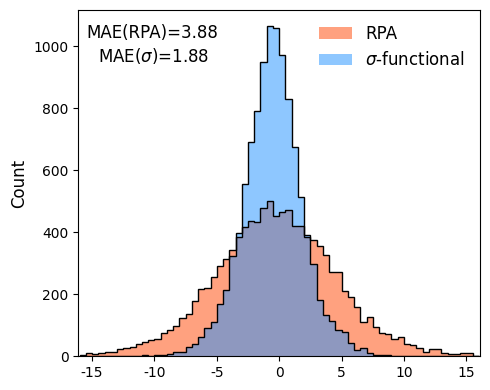

In [10]:
# Plot
plot_dev_histogram(e_calc, e_calc_rpa, e_ref, mae, mae_rpa)